Calculate Kuiper metric for a given cadence for each point of the sky.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

Basic experiments with randomly generated data and Kuiper metric

In [26]:
values=np.sort(100*np.random.random(30)+50)
period=5.
phased=(values%period)/period
phased=np.sort(phased)
phased2=np.array([v if (v<0.5 or v>0.6) else 0.8 for v in phased])
phased2=np.sort(phased2)

uniform = (np.arange(phased.size)+1)/phased.size

d_plus = np.max(uniform - phased)
d_minus = np.max(phased-uniform)
result = d_plus + d_minus

d_plus = np.max(uniform - phased2)
d_minus = np.max(phased2-uniform)
result2 = d_plus + d_minus

In [27]:
print(result, result2)

0.183384939939854 0.21098007305308314


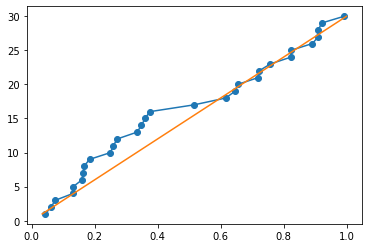

In [28]:
plt.plot(phased,np.cumsum(np.ones(phased.size)),marker='o')
plt.plot(uniform,np.cumsum(np.ones(uniform.size)))

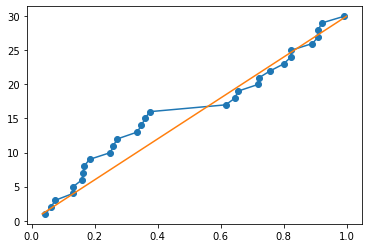

In [29]:
plt.plot(phased2,np.cumsum(np.ones(phased.size)),marker='o')
plt.plot(uniform,np.cumsum(np.ones(uniform.size)))

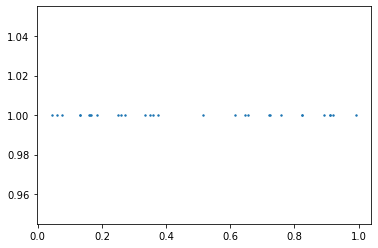

In [30]:
plt.scatter(phased,np.ones(phased.size),s=2)

Preparing MAF and Rubin_sim

In [2]:
# Grab the current baseline file. Should have been downloaded with rubin_sim. 
# Can grab lots of different sims from: http://astro-lsst-01.astro.washington.edu:8081/
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
conn = maf.db.OpsimDatabase(baseline_file)
outDir = 'temp'
resultsDb = maf.db.ResultsDb(outDir=outDir)

In [41]:
bundleList = []
# The point on the sky we would like to get visits for
#ra = [0.,5.]
#dec = [-20,-10]
#slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)

### Experimenting with HealpixSlicer
# Say we just want to pass data through, not compute anything. Documentation on the columns coming soon.
metric = maf.metrics.UniformityMetric()
# Select all the visits
sql = ''
slicer = maf.HealpixSlicer(nside=2**6)
bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [42]:
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database observations with no constraint for columns ['rotSkyPos', 'fieldRA', 'fieldDec', 'observationStartMJD'].
Found 2086980 visits
Running:  ['baseline_v2_0_10yrs_Uniformity_observationStartMJD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [43]:
# Our bundleList now has values. The trailing [0] is to get the first result. If we specified more
# ra,dec point, those results would be in the later indices.
bundleList[0].metricValues

masked_array(data=[--, --, --, ..., 0.17766678531584626,
                   0.1460656588391991, 0.22195848880959732],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=-1.6375e+30)

In [44]:
bundleList[0].metricValues.data

array([6.93031567e-310, 4.65849399e-310, 0.00000000e+000, ...,
       1.77666785e-001, 1.46065659e-001, 2.21958489e-001])

0.0 180.0 -180.0 180.0


Plotting figures with "" constraint now.


/mnt/Data/Work/GitHub/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 326 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.


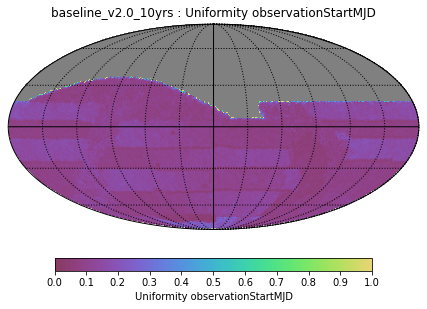

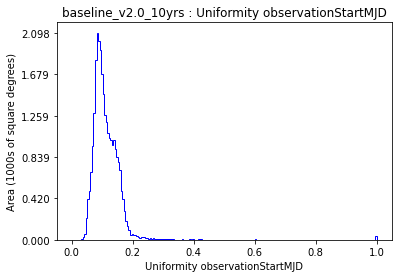

In [45]:
bg.plotAll(closefigs=False)

0.0 180.0 -180.0 180.0


{'SkyMap': 1}

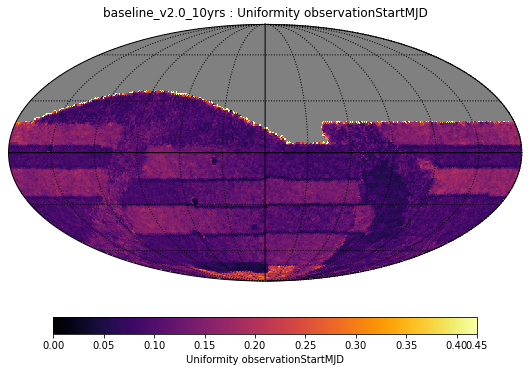

In [57]:
plotDict={
        "colorMin": 0,
        "colorMax": 0.42,
        "cmap": plt.get_cmap("inferno"),
        "figsize": (8, 5),
    }
metr=bg.bundleDict['baseline_v2_0_10yrs_Uniformity_observationStartMJD_HEAL']
metr.setPlotDict(plotDict)
metr.setPlotFuncs([maf.HealpixSkyMap()])
metr.plot()

Creating Kuiper metric

In [3]:
class KuiperVS(maf.BaseMetric):
    def __init__(self, mjdCol='observationStartMJD', units='', period=5, **kwargs):
        """surveyLength = time span of survey (years) """
        """period = assumed period of variability which will be used for calculating phase coverage by\
        observations. Measured in days"""
        self.mjdCol = mjdCol
        super(KuiperVS, self).__init__(col=self.mjdCol, units=units, **kwargs)
        self.period=period

    def run(self, dataSlice, slicePoint=None):
        # If only one observation, it's delta function and DKuiper=1
        if dataSlice[self.mjdCol].size == 1:
            return 1
        # Create phased cadence
        phased=np.sort((dataSlice[self.mjdCol]%self.period)/self.period)
        
        # Uniform cadence of the same size
        uniform = (np.arange(phased.size)+1)/phased.size

        d_plus = np.max(uniform - phased)
        d_minus = np.max(phased-uniform)
        result = d_plus + d_minus

        return result

In [4]:
# Say we just want to pass data through, not compute anything. Documentation on the columns coming soon.
metric = KuiperVS()
# Select all the visits
sql = ''
#slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
slicer = maf.HealpixSlicer(nside=2**6)
bundleList=[]
bundleList.append(maf.MetricBundle(metric, slicer, sql, runName='KuiperVSTest'))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [252]:
ra = [0.,5.]
dec = [-20,-10]
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundleList=[]
bundleList.append(maf.MetricBundle(metric, slicer, sql, runName='KuiperVSTest'))

In [5]:
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database observations with no constraint for columns ['rotSkyPos', 'fieldRA', 'fieldDec', 'observationStartMJD'].
Found 2086980 visits
Running:  ['KuiperVSTest_KuiperVS_observationStartMJD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


0.0 180.0 -180.0 180.0


Plotting figures with "" constraint now.


/mnt/Data/Work/GitHub/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 449 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.


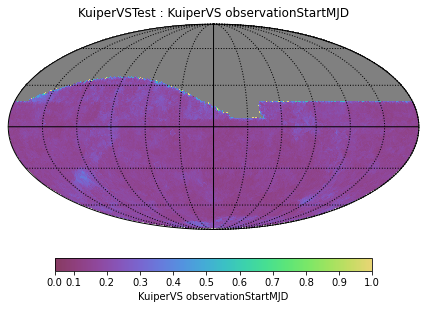

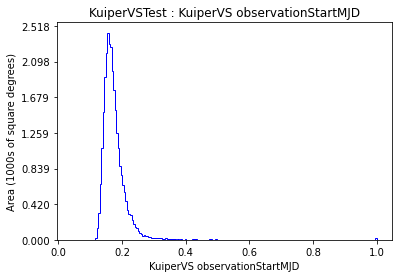

In [6]:
bg.plotAll(closefigs=False)

0.0 180.0 -180.0 180.0


{'SkyMap': 1}

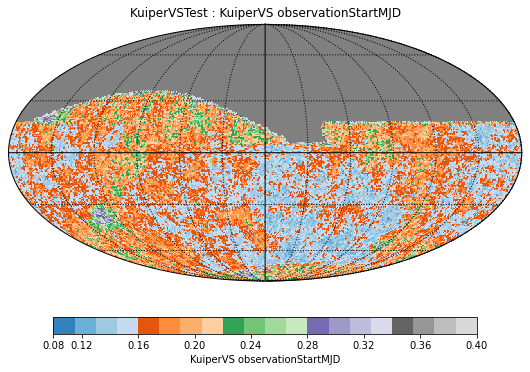

In [15]:
plotDict={
        "colorMin": 0.1,
        "colorMax": 0.4,
        "cmap": plt.get_cmap("tab20c"),
        "figsize": (8, 5),
    }
metr=bg.bundleDict['KuiperVSTest_KuiperVS_observationStartMJD_HEAL']
metr.setPlotDict(plotDict)
metr.setPlotFuncs([maf.HealpixSkyMap()])
metr.plot()

In [124]:
### Selecting regions with lowest and highest DKuiper for further comparison of phase coverage
arr=bundleList[0].metricValues.data
kuipLow=np.full_like(arr,False,dtype=bool)
kuipHigh=np.full_like(arr,False,dtype=bool)
kuipLow[np.where((arr <= 0.12) & (arr>0.08))]=True
kuipHigh[np.where((arr >= 0.3) & (arr<1))]=True

In [125]:
sidKuipLow=bundleList[0].slicer.slicePoints['sid'][kuipLow]
sidKuipHigh=bundleList[0].slicer.slicePoints['sid'][kuipHigh]

In [126]:
sidKuipLow.size

33

In [127]:
slicerKuipLow = maf.HealpixSubsetSlicer(nside=2**6,hpid=sidKuipLow)
slicerKuipHigh = maf.HealpixSubsetSlicer(nside=2**6,hpid=sidKuipHigh)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [128]:
metricKuipLowData = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
# Select all the visits
sql = ''
bundleListKuipLow=[]
bundleListKuipLow.append(maf.MetricBundle(metricKuipLowData, slicerKuipLow, sql, runName='KuipLow'))

In [129]:
metricKuipHighData = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
# Select all the visits
sql = ''
bundleListKuipHigh=[]
bundleListKuipHigh.append(maf.MetricBundle(metricKuipHighData, slicerKuipHigh, sql, runName='KuipHigh'))

In [130]:
bdKuipLow = maf.metricBundles.makeBundlesDictFromList(bundleListKuipLow)
bgKuipLow = maf.metricBundles.MetricBundleGroup(bdKuipLow, conn, 
                                                outDir=outDir, resultsDb=resultsDb)
bgKuipLow.runAll()

Querying database observations with no constraint for columns ['rotSkyPos', 'filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth'].
Found 2086980 visits
Running:  ['KuipLow_Pass_filter_observationStartMJD_fiveSigmaDepth_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [97]:
bdKuipHigh = maf.metricBundles.makeBundlesDictFromList(bundleListKuipHigh)
bgKuipHigh = maf.metricBundles.MetricBundleGroup(bdKuipHigh, conn, 
                                             outDir=outDir, resultsDb=resultsDb)
bgKuipHigh.runAll()

Querying database observations with no constraint for columns ['rotSkyPos', 'filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth'].
Found 2086980 visits
Running:  ['KuipHigh_Pass_filter_observationStartMJD_fiveSigmaDepth_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [131]:
len(bundleListKuipLow[0].metricValues.data[~bundleListKuipLow[0].metricValues.mask])

33

In [109]:
len(bundleListKuipHigh[0].metricValues.data[~bundleListKuipHigh[0].metricValues.mask])

377

/home/alex/anaconda3/envs/rubin/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/alex/anaconda3/envs/rubin/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/alex/anaconda3/envs/rubin/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alex/anaconda3/envs/rubin/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/alex/anaconda3/envs/rubin/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, cas

NameError: name 'ra' is not defined

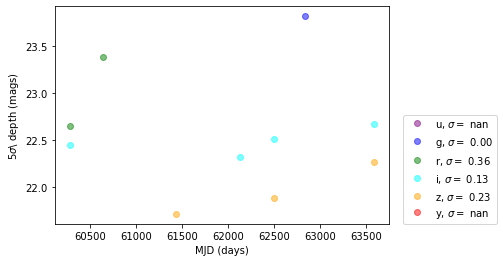

In [115]:
# As a bit of foreshadowing for how the rest of MAF works, we'll call the visits overlapping a
# single point in the sky "dataSlice". 
dataSlice = bundleListKuipHigh[0].metricValues.data[~bundleListKuipHigh[0].metricValues.mask][1]

# Let's plot up what the 5-sigma depth looks like
plt.figure()
# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(dataSlice['filter'] == fn)[0]
    plt.plot(dataSlice['observationStartMJD'][in_filt],
             dataSlice['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', $\sigma=$ %.2f' % (np.std(dataSlice['fiveSigmaDepth'][in_filt])),
             alpha=0.5)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$\ depth (mags)')
plt.legend(loc=(1.04,0))
plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))

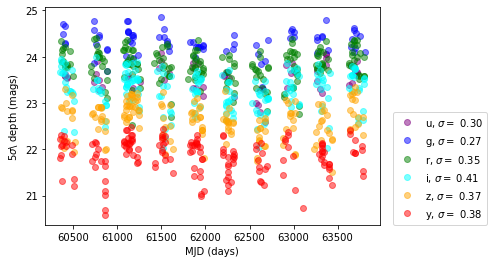

In [135]:
# As a bit of foreshadowing for how the rest of MAF works, we'll call the visits overlapping a
# single point in the sky "dataSlice". 
dataSlice = bundleListKuipLow[0].metricValues.data[~bundleListKuipLow[0].metricValues.mask][3]

# Let's plot up what the 5-sigma depth looks like
plt.figure()
# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(dataSlice['filter'] == fn)[0]
    plt.plot(dataSlice['observationStartMJD'][in_filt],
             dataSlice['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', $\sigma=$ %.2f' % (np.std(dataSlice['fiveSigmaDepth'][in_filt])),
             alpha=0.5)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$\ depth (mags)')
plt.legend(loc=(1.04,0))
#plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))